# 4. Correlation Analysis

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy import signal

plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 140

In [237]:
datadir = '../datasets/02/'
df = pd.read_csv(datadir + 'spikes_unit.csv', index_col=0)

display(df.head())

,unit,spiketime
0,0,-99618.990000
1,0,-96536.180002
2,0,-95920.130002
3,0,-93842.150003
4,0,-92885.660004


In [234]:
# filename = '../datasets/02/all.txt'
# spiketime = {}

# with open(filename) as f:
#     neuron_id = 0
#     spiketime[neuron_id] = []
    
#     for line in f:
#         value = line.rstrip()
        
#         if value == ';':
#             neuron_id += 1
#             spiketime[neuron_id] = []
#         else:
#             spiketime[neuron_id].append(value)
            
# lst_neurons = []
# lst_spiketime = []

# for key, value in spiketime.items():
#     lst_neurons.extend([key] * len(value))
#     lst_spiketime.extend(value)
    
# df = pd.DataFrame({'unit': lst_neurons, 'spiketime': lst_spiketime})
# df.to_csv('../datasets/02/spikes_unit.csv')

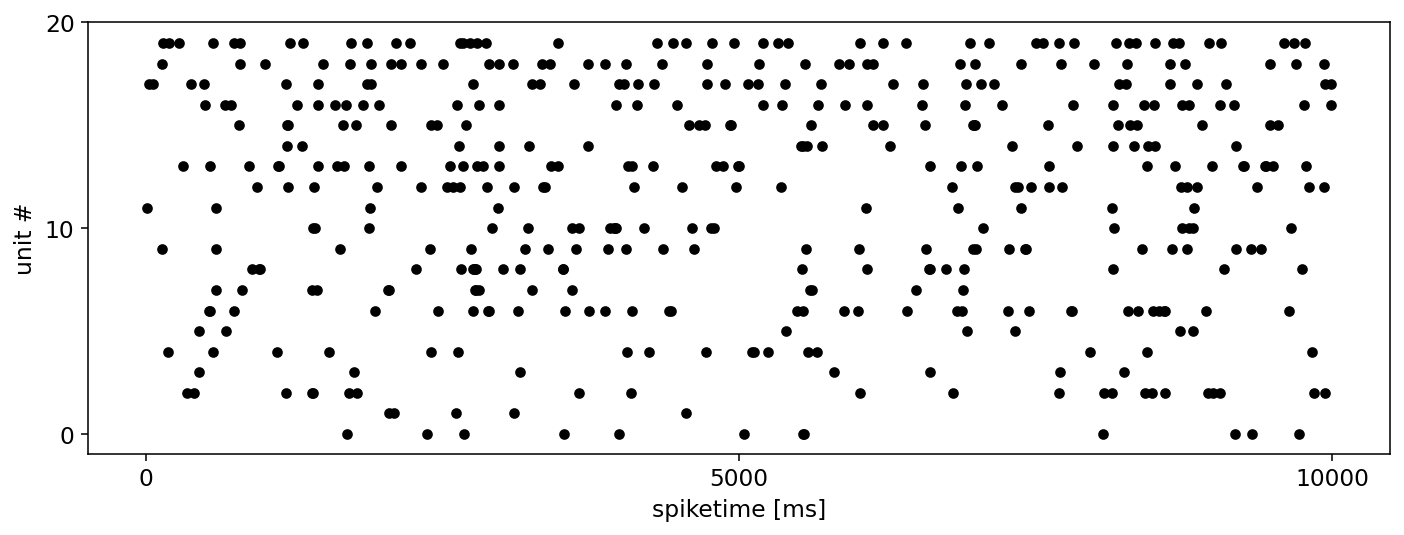

In [243]:
start, end = 0.0, 10000.0

fig, ax = plt.subplots(figsize=(12, 4))
df.query('@start <= spiketime <= @end').plot.scatter(x='spiketime', y='unit', c='k', ax=ax)
ax.set_xlabel('spiketime [ms]')
ax.set_ylabel('unit #')

ax.set_yticks([0, 10, 20])

plt.locator_params(axis='x', nbins=4)
plt.show()

## 4.1. Cross-Correlation

$W_{ij}$: neuron $j$からneuron $i$へのシナプス強度とする． 

In [252]:
def spiketime_relative(spike_times_i, spike_times_j, window_size=50.0):
    t_sp = []
    i_min, i_max = 0, 0

    for t_j in spike_times_j:
        # reuse search index for next iteration to decrease the amount of elements to scan
        i_min = _upper_bound_idx(lst=spike_times_i, upper=t_j - window_size, start_idx=i_min)
        i_max = _upper_bound_idx(lst=spike_times_i, upper=t_j + window_size, start_idx=i_max)
        t_sp.extend([(spike_times_i[i] - t_j) for i in range(i_min, i_max)])
        
    return t_sp

def _upper_bound_idx(lst, upper, start_idx=0):
    idx = start_idx
    while idx < len(lst) and lst[idx] <= upper:
        idx += 1
    return idx

def cross_correlogram(spike_times_i, spike_times_j, window=50., nbins=100):
    t_sp = spiketime_relative(spike_times_i, spike_times_j)
    hist, edges = np.histogram(t_sp, bins=np.linspace(-window, window, nbins))
    return hist, edges

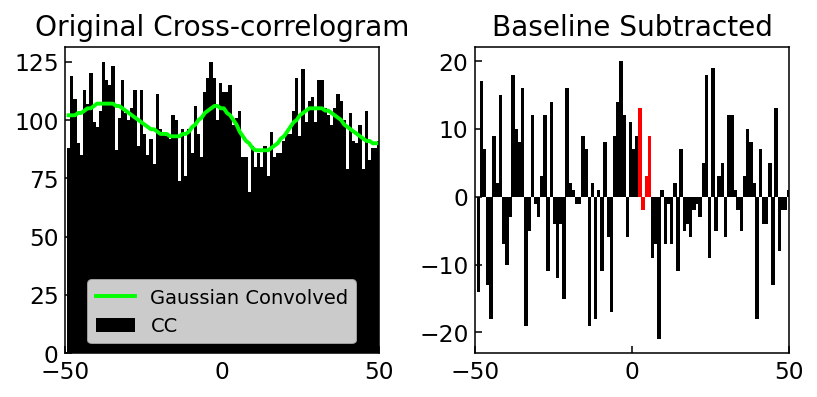

In [262]:
i, j = 8, 16
spike_times_i = df.query(f'unit=={i}').spiketime.values
spike_times_j = df.query(f'unit=={j}').spiketime.values

hist, edges = cross_correlogram(spike_times_i, spike_times_j)
hist_g = gaussian_filter(hist, sigma=[5])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.set_title('Original Cross-correlogram')
ax1.bar(edges[1:], hist, color='k', width=1.1, label='CC')
ax1.plot(edges[1:], hist_g, color='lime', linewidth=2.0, label='Gaussian Convolved')
ax1.legend(fontsize=10, loc='lower center')
ax1.set_xlim(-50, 50)
ax1.set_xticks([-50, 0, 50])
ax1.tick_params(direction='in')

hist_sub = hist - hist_g
ax2.set_title('Baseline Subtracted')
ax2.bar(edges[1:], hist_sub, color='k', width=1.1)
ax2.bar(edges[1:][51:55], hist_sub[51:55], color='r', width=1.1)
ax2.set_xlim(-50, 50)
ax2.set_xticks([-50, 0, 50])
ax2.tick_params(direction='in')

plt.tight_layout()
plt.show()

## 4.2. Effective Connectivity Mapping

In [86]:
import itertools
import seaborn as sns
import networkx as nx

In [263]:
def estimate_connectivity(spike_times_i, spike_times_j, start=1, end=5, window=50., nbins=100):
    hist, edges = cross_correlogram(spike_times_i, spike_times_j, window, nbins)
    hist_g = gaussian_filter(hist, sigma=[5])
    hist_sub = hist - hist_g

    w_ij = np.sum(hist_sub[nbins // 2 + start : nbins // 2 + end]) / len(spike_times_j)
    w_ji = np.sum(hist_sub[nbins // 2 - end : nbins // 2 - start]) / len(spike_times_i)
    return w_ij, w_ji

In [264]:
neurons = set(df.unit)
n_neurons = len(neurons)
w = np.zeros((n_neurons, n_neurons))

for (i, j) in itertools.combinations(neurons, 2):
    if i == j:
        continue
    else:
        spike_times_i = df.query(f'unit=={i}').spiketime.values
        spike_times_j = df.query(f'unit=={j}').spiketime.values
        w_ij, w_ji = estimate_connectivity(spike_times_i, spike_times_j)
        w[i, j] = w_ij
        w[j, i] = w_ji

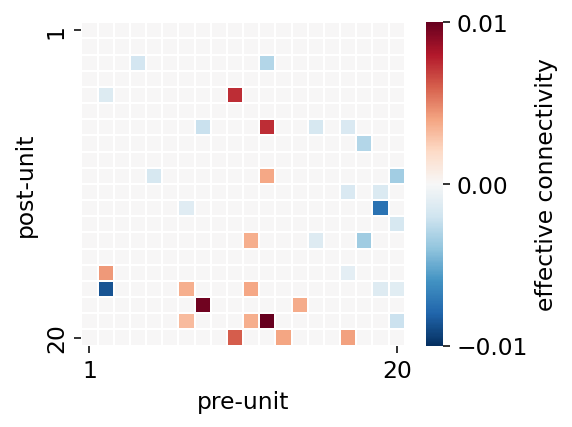

In [285]:
fig, ax = plt.subplots(figsize=(4, 3))

w_ = np.zeros_like(w)

thre_exc = 0.003
thre_inh = 0.001
w_[w > thre_exc] = w[w > thre_exc]
w_[w < -thre_inh] = w[w < -thre_inh]

sns.heatmap(w_, vmax=0.01, vmin=-0.01, center=0, ax=ax, cmap=plt.get_cmap('RdBu_r'), 
            linewidths=1.0, cbar_kws=dict(ticks=[0.01, 0, -0.01], label='effective connectivity'))

ax.set_xticks([0.5, 19.5])
ax.set_yticks([0.5, 19.5])
ax.set_xticklabels([1, 20])
ax.set_yticklabels([1, 20])

ax.set_xlabel('pre-unit')
ax.set_ylabel('post-unit')
ax.set_aspect('equal')
plt.show()

In [286]:
G = nx.DiGraph()

for neuron in neurons:
    G.add_node(neuron + 1)

for i in range(w.shape[0]):
    for j in range(w.shape[1]):
        w_ij = w[i, j]
        if w_ij > thre_exc:
            G.add_edge(i + 1, j + 1, weight=w_ij, color='magenta')  # exc
        elif w_ij < -thre_inh:
            G.add_edge(i + 1, j + 1, weight=w_ij, color='cyan')  # inh

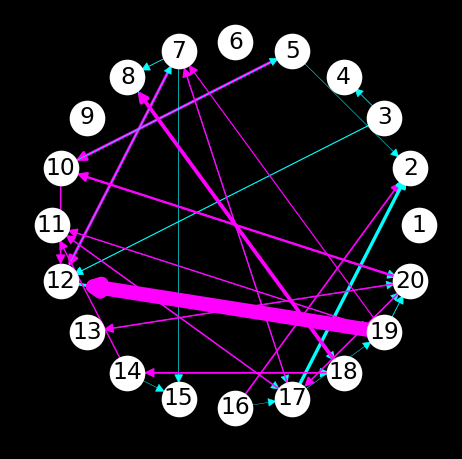

In [287]:
edges = G.edges()
edge_color = [G[u][v]['color'] for u, v in edges]
edge_width = [G[u][v]['weight'] * 200 for u, v in edges]

fig, ax = plt.subplots(figsize=(4, 4))
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_color='w', font_color='k', 
        edge_color=edge_color, width=edge_width, arrows=True, arrowsize=10)

fig.set_facecolor('k')
plt.show()

## 4.3. Visualizing Interactive Network with Bokeh

In [278]:
from bokeh.io import show, output_notebook
from bokeh.plotting import curdoc, figure, from_networkx
from bokeh.models import Range1d, Circle, MultiLine, NodesAndLinkedEdges
from bokeh.palettes import Spectral8
output_notebook()

Loading BokehJS ...

In [279]:
def make_network_plot(G):
    node_highlight_color = Spectral8[4]
    edge_highlight_color = Spectral8[4]
    
    HOVER_TOOLTIPS = [("neuron", "@index"), ("degree", "@degree")]
    plot = figure(tooltips = HOVER_TOOLTIPS, tools="pan,box_zoom,wheel_zoom,save,reset", width=500, height=500)
    
    plot.axis.major_tick_line_color = None
    plot.axis.minor_tick_line_color = None
    plot.axis.major_label_text_color = None  
    plot.xgrid.visible = False
    plot.ygrid.visible = False  
    
    network_graph = from_networkx(G, nx.circular_layout, scale=8, center=(0, 0))
    network_graph.node_renderer.glyph = Circle(size=30, fill_color='white', fill_alpha=0.7)
    network_graph.node_renderer.hover_glyph = Circle(size=30, fill_color=node_highlight_color, line_width=2)
    network_graph.node_renderer.selection_glyph = Circle(size=30, fill_color=node_highlight_color, line_width=2)

    network_graph.edge_renderer.glyph = MultiLine(line_color='edge_color', line_alpha=0.9, line_width='edge_width')
    network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width='edge_width')
    network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width='edge_width')
    
    network_graph.selection_policy = NodesAndLinkedEdges()
    network_graph.inspection_policy = NodesAndLinkedEdges()
    plot.renderers.append(network_graph)
    return plot

In [288]:
# node attributes
nx.set_node_attributes(G, name='degree', values=dict(nx.degree(G)))

# edge attributes
edges = G.edges()
edge_color = {(u, v): G[u][v]['color'] for u, v in edges}
edge_width = {(u, v): G[u][v]['weight'] * 200 for u, v in edges}

nx.set_edge_attributes(G, edge_color, "edge_color")
nx.set_edge_attributes(G, edge_width, "edge_width")

curdoc().theme = 'dark_minimal'
p = make_network_plot(G)
show(p)